# Traditional CNN auf den preprocessed Event-Features
Dieses Notebook nutzt die bereits gespeicherten Daten aus `data/processed` (aus `preprocess_data.py`).
Wir:
- laden `X_train/X_val/X_test` und `y_*` (One-Hot Labels)
- rekonstruieren daraus Bilder mit 2 Kanälen (pos/neg Time-Surface)
- visualisieren ein paar Beispiele
- trainieren ein kleines CNN und testen es auf dem Testset.

In [8]:
# Setup / Imports
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# Damit `models/...` importierbar ist (Notebook liegt in notebooks/traditionalNN/)
sys.path.insert(0, str(Path('..').resolve()))
sys.path.insert(0, str(Path('../..').resolve()))

from models.preprocessing import load_preprocessed
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", tf.config.list_physical_devices('GPU'))


Num GPUs Available:  []


In [9]:
# Daten laden
data_dir = Path('../../data/processed')
splits, class_names = load_preprocessed(data_dir)
X_train, y_train = splits['train']
X_val, y_val = splits['val']
X_test, y_test = splits['test']

print('Class names:', class_names)
print('X_train:', X_train.shape, 'y_train:', y_train.shape)
print('X_val:  ', X_val.shape, 'y_val:  ', y_val.shape)
print('X_test: ', X_test.shape, 'y_test: ', y_test.shape)

n_features = X_train.shape[1]
n_classes = y_train.shape[1]
print('n_features:', n_features)
print('n_classes :', n_classes)

# Wir rekonstruieren ein Bild mit 2 Kanälen aus dem Feature-Vektor.
# In models/preprocessing.py: time_surface -> concat([surface_pos.flatten(), surface_neg.flatten()])
if n_features % 2 != 0:
    raise ValueError(f'Erwarte gerade Feature-Anzahl (pos+neg), bekommen: {n_features}')

hw = n_features // 2
# Count samples per class
class_counts = np.sum(y_train, axis=0).astype(int)
for i, class_name in enumerate(class_names):
    print(f'{class_name}: {class_counts[i]} samples')
print(f'Total: {np.sum(class_counts)} samples')

known_shapes = {
    640 * 480: (480, 640),
    64 * 48: (48, 64),
    320 * 240: (240, 320),
}
if hw not in known_shapes:
    raise ValueError(
        f'Unbekannte Bildgröße: hw={hw}. '
        'Passe known_shapes an oder ändere das Preprocessing so, dass width/height bekannt sind.'
    )
H, W = known_shapes[hw]
print('Rekonstruiertes Bildformat:', (H, W, 2))

Loaded train: X=(1015, 614400), y=(1015, 10)
Loaded val: X=(290, 614400), y=(290, 10)
Loaded test: X=(146, 614400), y=(146, 10)
Loaded class names: ['benjamin', 'christian', 'felix', 'jonas', 'leon', 'mark', 'marvin', 'ohman', 'veronica', 'yannes']
Class names: ['benjamin', 'christian', 'felix', 'jonas', 'leon', 'mark', 'marvin', 'ohman', 'veronica', 'yannes']
X_train: (1015, 614400) y_train: (1015, 10)
X_val:   (290, 614400) y_val:   (290, 10)
X_test:  (146, 614400) y_test:  (146, 10)
n_features: 614400
n_classes : 10
benjamin: 18 samples
christian: 33 samples
felix: 28 samples
jonas: 28 samples
leon: 30 samples
mark: 208 samples
marvin: 331 samples
ohman: 26 samples
veronica: 33 samples
yannes: 280 samples
Total: 1015 samples
Rekonstruiertes Bildformat: (480, 640, 2)


In [10]:
# Filter to keep only 'yannes', 'marvin', and 'christian' classes
keep_classes = ['yannes', 'marvin', 'mark']
keep_indices = [class_names.index(c) for c in keep_classes]

# Filter training data
train_mask = np.isin(np.argmax(y_train, axis=1), keep_indices)
X_train = X_train[train_mask]
y_train = y_train[train_mask][:, keep_indices]

# Filter validation data
val_mask = np.isin(np.argmax(y_val, axis=1), keep_indices)
X_val = X_val[val_mask]
y_val = y_val[val_mask][:, keep_indices]

# Filter test data
test_mask = np.isin(np.argmax(y_test, axis=1), keep_indices)
X_test = X_test[test_mask]
y_test = y_test[test_mask][:, keep_indices]

# Update class_names and n_classes
class_names = keep_classes
n_classes = len(class_names)

print('Filtered class names:', class_names)
print('X_train:', X_train.shape, 'y_train:', y_train.shape)
print('X_val:  ', X_val.shape, 'y_val:  ', y_val.shape)
print('X_test: ', X_test.shape, 'y_test: ', y_test.shape)
print('n_classes:', n_classes)

# Count samples per class
class_counts = np.sum(y_train, axis=0).astype(int)
for i, class_name in enumerate(class_names):
    print(f'{class_name}: {class_counts[i]} samples')
print(f'Total: {np.sum(class_counts)} samples')

Filtered class names: ['yannes', 'marvin', 'mark']
X_train: (819, 614400) y_train: (819, 3)
X_val:   (234, 614400) y_val:   (234, 3)
X_test:  (118, 614400) y_test:  (118, 3)
n_classes: 3
yannes: 280 samples
marvin: 331 samples
mark: 208 samples
Total: 819 samples


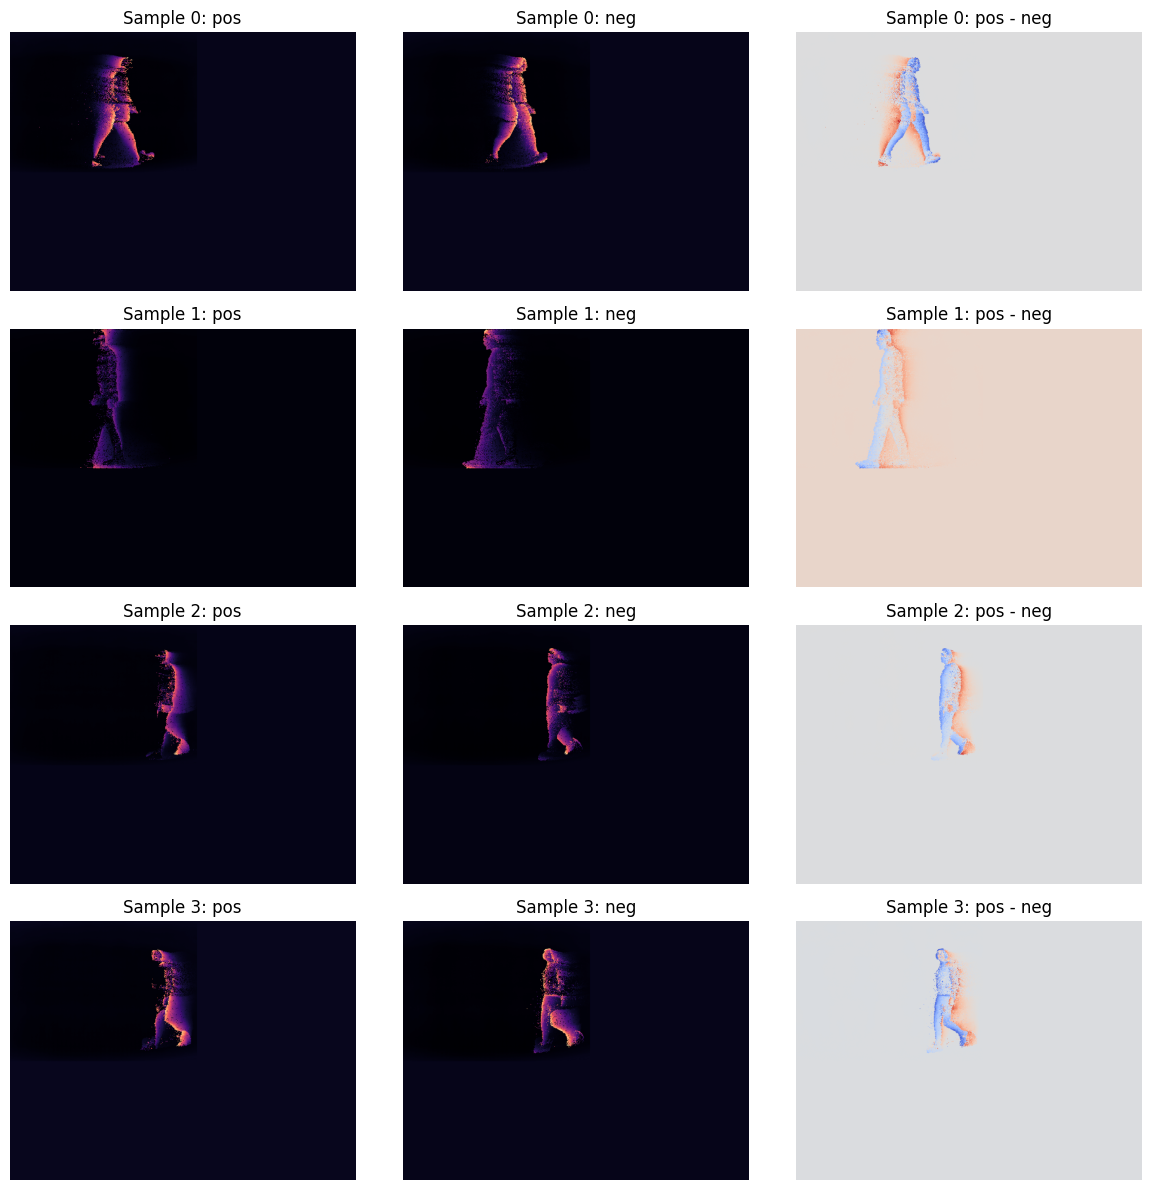

In [11]:
# Kurze Visualisierung (ein paar Samples)
def vector_to_image_np(x_vec: np.ndarray, H: int, W: int) -> np.ndarray:
    x_vec = np.asarray(x_vec)
    hw = H * W
    pos = x_vec[:hw].reshape(H, W)
    neg = x_vec[hw:hw*2].reshape(H, W)
    img = np.stack([pos, neg], axis=-1)  # (H, W, 2)
    return img

n_show = min(4, len(X_train))
fig, axes = plt.subplots(n_show, 3, figsize=(12, 3 * n_show))
if n_show == 1:
    axes = np.expand_dims(axes, axis=0)

for i in range(n_show):
    img = vector_to_image_np(X_train[i], H, W)
    pos = img[..., 0]
    neg = img[..., 1]
    diff = pos - neg
    axes[i, 0].imshow(pos, cmap='magma')
    axes[i, 0].set_title(f'Sample {i}: pos')
    axes[i, 1].imshow(neg, cmap='magma')
    axes[i, 1].set_title(f'Sample {i}: neg')
    axes[i, 2].imshow(diff, cmap='coolwarm')
    axes[i, 2].set_title(f'Sample {i}: pos - neg')
    for j in range(3):
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()

In [12]:
# tf.data Pipeline: Vektor -> (H,W,2) ohne große Copies
AUTOTUNE = tf.data.AUTOTUNE

def to_image_tf(x_vec, y):
    x_vec = tf.cast(x_vec, tf.float32)
    hw = H * W
    pos = tf.reshape(x_vec[:hw], (H, W, 1))
    neg = tf.reshape(x_vec[hw:hw*2], (H, W, 1))
    img = tf.concat([pos, neg], axis=-1)  # (H, W, 2)
    y = tf.cast(y, tf.float32)
    return img, y

batch_size = 16
ds_train = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .shuffle(min(len(X_train), 2000), seed=42, reshuffle_each_iteration=True)
    .map(to_image_tf, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)
ds_val = (
    tf.data.Dataset.from_tensor_slices((X_val, y_val))
    .map(to_image_tf, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)
ds_test = (
    tf.data.Dataset.from_tensor_slices((X_test, y_test))
    .map(to_image_tf, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

# Sanity-check: ein Batch
x_b, y_b = next(iter(ds_train))
print('Batch X:', x_b.shape, 'Batch y:', y_b.shape)

Batch X: (16, 480, 640, 2) Batch y: (16, 3)


In [13]:
# Transformer / ViT-like Modell
target_h, target_w = 96, 128   # muss durch patch teilbar sein
patch = 8                      # 96/8=12, 128/8=16 => 192 Tokens
embed_dim = 128
num_heads = 4
mlp_dim = 256
num_blocks = 4
dropout = 0.1

def transformer_block(x):
    # Self-Attention
    y = layers.LayerNormalization(epsilon=1e-6)(x)
    y = layers.MultiHeadAttention(
        num_heads=num_heads,
        key_dim=embed_dim // num_heads,
        dropout=dropout,
    )(y, y)
    x = layers.Add()([x, y])

    # MLP
    y = layers.LayerNormalization(epsilon=1e-6)(x)
    y = layers.Dense(mlp_dim, activation='gelu')(y)
    y = layers.Dropout(dropout)(y)
    y = layers.Dense(embed_dim)(y)
    x = layers.Add()([x, y])
    return x

inp = layers.Input(shape=(H, W, 2))
x = layers.Resizing(target_h, target_w)(inp)

# Patch Embedding (Conv2D mit stride=patch entspricht "patchify + linear proj")
x = layers.Conv2D(embed_dim, kernel_size=patch, strides=patch, padding='valid')(x)
# (B, H/patch, W/patch, embed_dim) -> (B, N, embed_dim)
x = layers.Reshape((-1, embed_dim))(x)

# Positional Embedding
num_patches = (target_h // patch) * (target_w // patch)
pos = tf.range(start=0, limit=num_patches, delta=1)
pos_emb = layers.Embedding(input_dim=num_patches, output_dim=embed_dim)(pos)
x = x + pos_emb

for _ in range(num_blocks):
    x = transformer_block(x)

x = layers.LayerNormalization(epsilon=1e-6)(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(dropout)(x)
out = layers.Dense(n_classes, activation='softmax')(x)

model = keras.Model(inp, out)

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 480, 640, 2  0           []                               
                                )]                                                                
                                                                                                  
 resizing_1 (Resizing)          (None, 96, 128, 2)   0           ['input_2[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 12, 16, 128)  16512       ['resizing_1[0][0]']             
                                                                                                  
 reshape_1 (Reshape)            (None, 192, 128)     0           ['conv2d_1[0][0]']         

In [25]:
# Training
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True),
]

history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=100,
    #callbacks=callbacks,
)

Epoch 1/100
52/52 [==============================] - 5s 90ms/step - loss: 0.3632 - accuracy: 0.8571 - val_loss: 1.1779 - val_accuracy: 0.5812
Epoch 2/100
52/52 [==============================] - 5s 87ms/step - loss: 0.3596 - accuracy: 0.8620 - val_loss: 1.1117 - val_accuracy: 0.6282
Epoch 3/100
52/52 [==============================] - 5s 90ms/step - loss: 0.2766 - accuracy: 0.8974 - val_loss: 1.2672 - val_accuracy: 0.6239
Epoch 4/100
52/52 [==============================] - 5s 90ms/step - loss: 0.2466 - accuracy: 0.8999 - val_loss: 1.4899 - val_accuracy: 0.5983
Epoch 5/100
52/52 [==============================] - 5s 88ms/step - loss: 0.3251 - accuracy: 0.8620 - val_loss: 1.3274 - val_accuracy: 0.5769
Epoch 6/100
52/52 [==============================] - 4s 85ms/step - loss: 0.2870 - accuracy: 0.8987 - val_loss: 1.3046 - val_accuracy: 0.6282
Epoch 7/100
52/52 [==============================] - 5s 89ms/step - loss: 0.2266 - accuracy: 0.9243 - val_loss: 1.4050 - val_accuracy: 0.6282
Epoch 

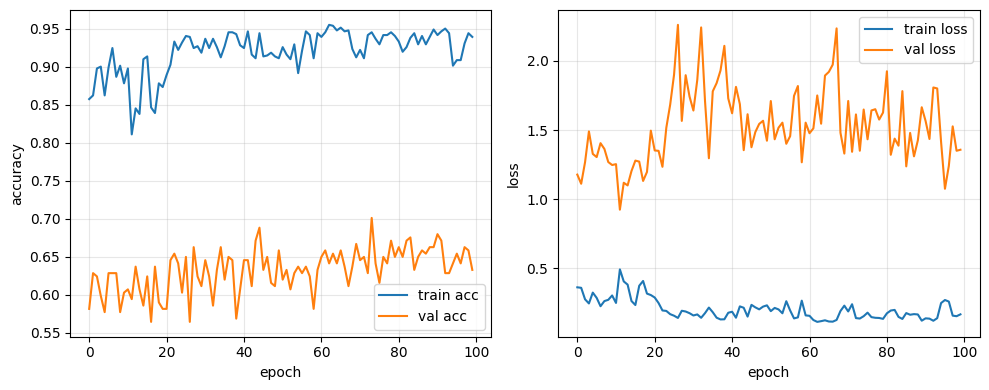

In [26]:
# Training-Kurven (kurz)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history.get('accuracy', []), label='train acc')
plt.plot(history.history.get('val_accuracy', []), label='val acc')
plt.xlabel('epoch'); plt.ylabel('accuracy'); plt.legend(); plt.grid(alpha=0.3)
plt.subplot(1,2,2)
plt.plot(history.history.get('loss', []), label='train loss')
plt.plot(history.history.get('val_loss', []), label='val loss')
plt.xlabel('epoch'); plt.ylabel('loss'); plt.legend(); plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [28]:
# Testing / Evaluation am Testset
test_loss, test_acc = model.evaluate(ds_test, verbose=1)
print(f'Test loss: {test_loss:.4f}')
print(f'Test acc : {test_acc:.4f}')

# (Optional) ein paar Vorhersagen anzeigen


8/8 [==============================] - 0s 27ms/step - loss: 1.6427 - accuracy: 0.6102
Test loss: 1.6427
Test acc : 0.6102


In [29]:
n_pred = 5
for batch_x, batch_y in ds_test.take(1):
    probs = model.predict(batch_x, verbose=0)
    y_true = tf.argmax(batch_y, axis=1).numpy()
    y_pred = tf.argmax(probs, axis=1).numpy()
    # Confidence (probability) of the predicted class for each sample
    confidences = probs[np.arange(probs.shape[0]), y_pred]
    for i in range(min(n_pred, len(y_true))):
        print(f'Sample {i}: true={class_names[y_true[i]]}, pred={class_names[y_pred[i]]}, conf={confidences[i]:.3f}')

Sample 0: true=yannes, pred=yannes, conf=1.000
Sample 1: true=yannes, pred=yannes, conf=1.000
Sample 2: true=mark, pred=mark, conf=0.998
Sample 3: true=marvin, pred=yannes, conf=0.952
Sample 4: true=marvin, pred=marvin, conf=0.962
